# Creating layouts for fabrication by programming KLayout

### Software installation:

***KLayout***

> pip install klayout

***SiEPIC-Tools***

1) via pip from PyPI distribution, 

> pip install siepic

2) or, via pip & GitHub Desktop:

> python -m pip install -e '/Users/lukasc/Documents/GitHub/SiEPIC-Tools/klayout_dot_config/python'


***Your Choosen PDK and Library***

I am using SiEPICfab-EBeam-ZEP-PDK

Follow the instructions outlined in teh README here for installation:

https://github.com/SiEPIC/SiEPICfab-EBeam-ZEP-PDK

This can be generalized to the import method i have listed below!


In [1]:
import pya
from pya import *
import SiEPIC
from SiEPIC._globals import Python_Env
from SiEPIC.scripts import connect_cell, connect_pins_with_waveguide, zoom_out, export_layout
from SiEPIC.utils import create_cell2, get_layout_variables
from SiEPIC.utils.layout import new_layout, floorplan, coupler_array
from SiEPIC.extend import to_itype
from SiEPIC.verification import layout_check
import numpy as np
from SiEPIC.scripts import connect_pins_with_waveguide, connect_cell
import os
import sys


KLayout SiEPIC-Tools version 0.5.24
SiEPIC-Tools is up to date (0.5.24 vs 0.5.24).
Version check, time: 0.8351755142211914 seconds


In [ ]:

if Python_Env == 'Script':

    # Define the path to your local PDK
    path_GitHub = r"C:\Users\gamem\OneDrive - UBC\Documents\GitHub"
    sys.path.insert(0, os.path.join(path_GitHub, "SiEPICfab-EBeam-ZEP-PDK"))

    # Now try importing the PDK
    import SiEPICfab_EBeam_ZEP


tech_name = 'SiEPICfab_EBeam_ZEP'


SiEPICfab-EBeam-ZEP Python module: siepicfab_ebeam_zep, KLayout technology: SiEPICfab_EBeam_ZEP
SiEPICfab-EBeam-ZEP Python module: pymacros, v0.1.5
Libraries associated with Technology SiEPICfab_EBeam_ZEP: ['SiEPICfab_EBeam_ZEP', 'SiEPICfab_EBeam_ZEP_Beta']
Libraries associated with Technology SiEPICfab_EBeam_ZEP: ['SiEPICfab_EBeam_ZEP', 'SiEPICfab_EBeam_ZEP_Beta']


In [ ]:

designer_name = 'MateoBC'
top_cell_name = 'MateoBC'
export_type = 'static'  # static: for fabrication, PCell: include PCells in file

_, ly = new_layout(tech_name, top_cell_name, GUI=True, overwrite = True)
_, ly_preserve_floorplan = new_layout(tech_name, top_cell_name, GUI=True, overwrite = True)
folder = os.path.join(path_GitHub, "SiEPICfab_ZEP_SNSPDPASSIVE_202504", "thin zep")
layout_file = os.path.join(folder, f"{designer_name}.oas")
ly.read(layout_file)
ly_preserve_floorplan.read(layout_file)
# Access the top cell
top_cell = ly.top_cell()
top_cell_floorplanonly = ly_preserve_floorplan.top_cell() # This cell will only have the floorplan and is for resetting the oas file

dbu = ly.dbu
wg_bend_radius = 20
              

top_cell.plot() # in the browser

In [4]:
top_cell.bbox().width()*dbu, top_cell.bbox().height()*dbu, top_cell.bbox().right, top_cell.bbox().top # just useful to confirm the size of the cell

(6220.009999999998, 2876.8099999999995, 6220010, 2876810)

In [5]:
# === Function to create a single apodized Bragg grating device ===
def ebeam_bragg_apodized(x_pos_GC, y_pos_GC, cellname, device_label, xmax, grating_period):
    # Create a new device cell
    cell = ly.create_cell(cellname)
    t = Trans(Trans.R0, 0 / dbu, 0 / dbu)
    top_cell.insert(CellInstArray(cell.cell_index(), t))

    # Parameters
    wg_width = 0.5  # Waveguide width in microns
    GC_pitch = 127.  # Grating coupler pitch in microns
    num_gc = 4  # Number of grating couplers

    # Load PDK cells
    cell_gc = create_cell2(ly, "ebeam_GC_Air_te1550", tech_name)
    cell_ybranch = create_cell2(ly, "ebeam_ybranch_te1550", "SiEPICfab_EBeam_ZEP_Beta")

    # Auto-position starting GC array near top-left of floorplan if x/y == (0, top)
    if x_pos_GC == 0 and y_pos_GC == top_cell.bbox().height() * dbu:
        x_pos_GC = cell_gc.bbox().width() * dbu
        y_pos_GC -= (num_gc - 1) * GC_pitch + cell_gc.bbox().height() * dbu / 2

    # Place grating coupler array
    inst_GCs = coupler_array(
        cell,
        cell_name="ebeam_GC_Air_te1550",
        cell_library=tech_name,
        x_offset=x_pos_GC / dbu,
        y_offset=y_pos_GC / dbu,
        label=device_label,
        label_location=2,
        count=num_gc,
    )

    # Connect second GC to y-branch
    inst_ybranch = connect_cell(inst_GCs[1], "opt1", cell_ybranch, "opt1")

    # Define Bragg grating with apodization
    cell_bragg = ly.create_cell(
        "ebeam_bragg_apodized",
        "SiEPICfab_EBeam_ZEP_Beta",
        {"number_of_periods": 1000, "grating_period": grating_period, "corrugation_width": 0.02}
    )

    # Position Bragg grating relative to Y-branch
    gc_length = inst_ybranch.bbox().right * dbu + wg_bend_radius + inst_ybranch.bbox().width() * dbu / 2
    y_pos_bragg = y_pos_GC - GC_pitch - 25
    t = Trans(Trans.R270, gc_length / dbu, y_pos_bragg / dbu)
    inst_bragg = cell.insert(CellInstArray(cell_bragg.cell_index(), t))

    # Connect Y-branch again to Bragg grating
    inst_ybranch2 = connect_cell(inst_bragg, "opt1", cell_ybranch, "opt1")

    # Waveguide parameters
    wg_type = "Strip TE 1550 nm, w=500 nm (core-clad)"

    # Interconnect all components
    connect_pins_with_waveguide(inst_GCs[0], "opt1", inst_ybranch2, "opt3", waveguide_type=wg_type, r=wg_bend_radius)
    connect_pins_with_waveguide(inst_ybranch, "opt2", inst_ybranch2, "opt2", waveguide_type=wg_type, r=wg_bend_radius)
    connect_pins_with_waveguide(inst_GCs[2], "opt1 ", inst_ybranch, "opt3", waveguide_type=wg_type, r=wg_bend_radius)

    # Use turtle path for the last GC → Bragg grating
    connect_pins_with_waveguide(
        inst_GCs[3], "opt1 ", inst_bragg, "opt2",
        turtle_A=[
            wg_bend_radius, -90,  # Right bend
            wg_bend_radius, 90    # Left bend
        ],
        waveguide_type=wg_type, r=wg_bend_radius
    )

    # === Update placement coordinates for next device ===
    # Attempt to place next device to the right
    next_x = cell.bbox().right * dbu + 20 + cell_gc.bbox().width() * dbu
    next_y = y_pos_GC

    # If placement exceeds floorplan width, wrap to next row
    if next_x + cell.bbox().width() * dbu > xmax:
        next_x = cell_gc.bbox().width() * dbu
        next_y = cell.bbox().bottom * dbu - (num_gc - 1) * GC_pitch - cell_gc.bbox().height() * dbu / 2

    return next_x, next_y, xmax


In [6]:
# Start near top-left of floorplan
x = 0
y = top_cell.bbox().height() * dbu
xmax = top_cell.bbox().width() * dbu

# Define grating period range (in microns)
grating_periods = np.arange(0.310, 0.336, 1e-3)  # 310 nm to 335 nm
k = 1  # Instance counter

# Loop to place multiple devices
for gp in grating_periods:
    for k in range(1,4):
        gp_nm = int(gp * 1000)  # Convert to nm for labeling
        cellname = f"ebeam_bragg_apodized{gp_nm}_{k}"
        label = f"opt_in_TE_1550_device_Mateo_bragg_1000N{gp_nm}nmPeriod500nmW20nmdW0Apo_{k}"
        x, y, xmax = ebeam_bragg_apodized(x, y, cellname, label, xmax, gp)


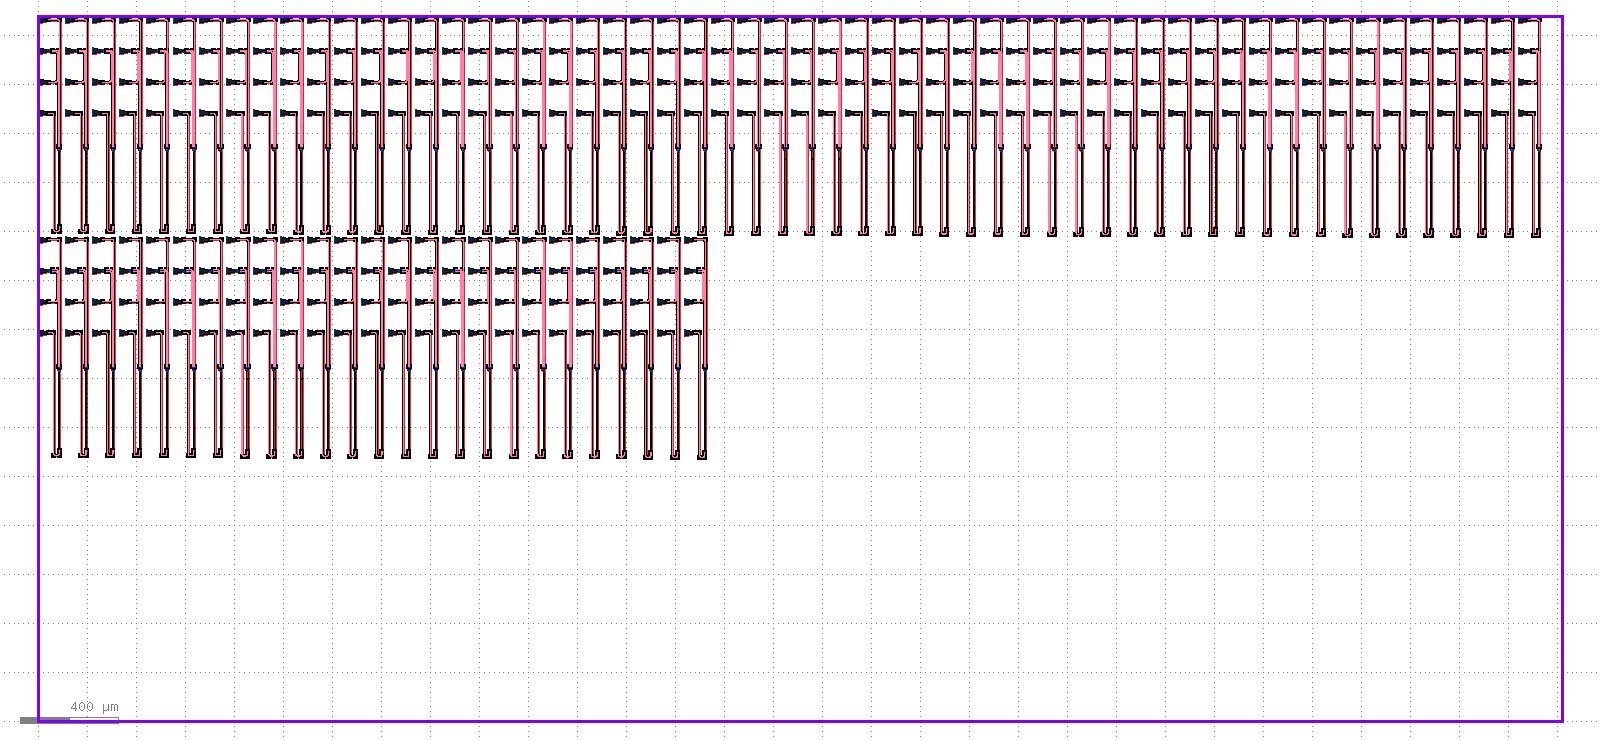

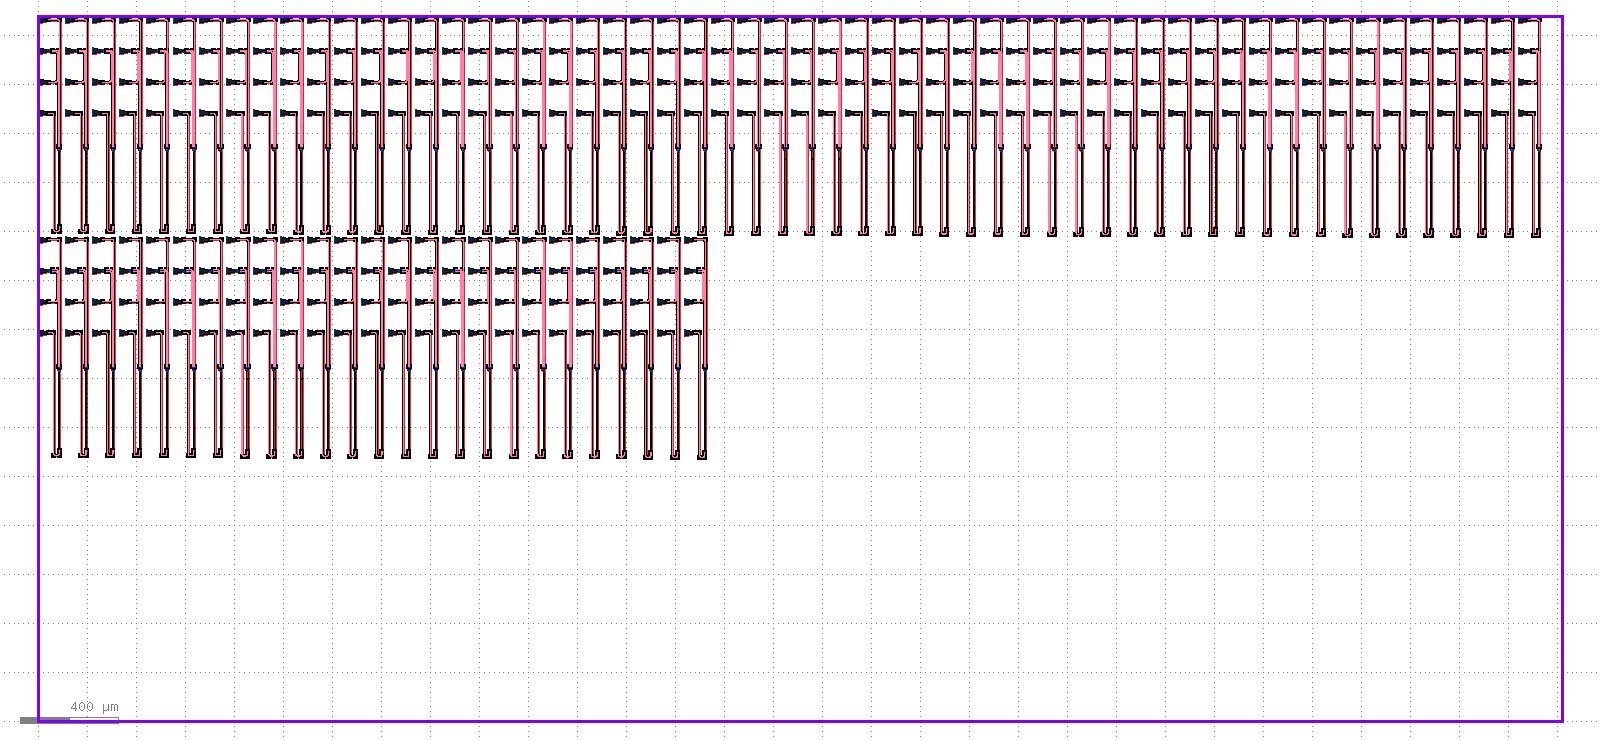

In [7]:
# Zoom out
# zoom_out(cell)
# top_cell.show() # in KLayout GUI
top_cell.plot() # in the browser

In [8]:
ly.write(layout_file)


### This is to reset your oas file to the default floorplan


In [ ]:
ly_preserve_floorplan.write(layout_file)